# Hyperparameter scan

Ok, so I know that it's a better idea to use a random search to scan for hyperparameters, but since this is my first time doing R&D for this model, I think I might be useful to invest a bit of time in understanding *which* of the hyperparameters are important!

The script in `hyperparamScan` trains 54 models, so this notebook loads in these models and looks at some of the performance metrics!

**Table of Contents**
1. Dependence on the # of layers
2. Dependence on the size of the layers
2. Dependence on the size of the latent dimension
2. Dependence on dropout

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot
from tqdm import tqdm
import glob 

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from root_to_np import get_sort_index, passJet, saveData, loadData, getdR, scale
from matplotlib.colors import LogNorm, Normalize 
from termcolor import colored

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Data**

Open the test dataset: 1.5m ttbar pflow jets

In [2]:
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

jetCollection = 'PFlow'
subDir = 'mc16d_{}_ttbar'.format(jetCollection)
dataDir = '../../data/'+subDir
dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

_, nTrks, nFeatures = X.shape
dataTagTrain = "2mtrain_15trks_{}".format(vStr)

**First step:**

Let's just load in some of the models and overlay the roc curves to see if something obvious sticks out! 


In [3]:
modelDir = '../../models/'+subDir
figDir = '../../figures/'

In [4]:
def getParams(layers):
    '''
    Given the dimensions of an mlp, starting from the input and output dimensions,
    return the # of trainable params (assuming a bias is being included as well) 
    '''
    
    nWs = [(l1+1)*l2 for l1,l2 in zip(layers[:-1],layers[1:])]
    return sum(nWs)

In [5]:
leffs, ceffs, beffs, discs, labels = [], [], [], [], []

nPhis, nFs, = [],[]
lrej_70,crej_70 = [],[]
WP = 0.7
debug = False

for dense_layers in [1,2,3]:
    for dense_size in [50, 100]:
        
        dense_sizes = [dense_size] * dense_layers
        
        for latent_dim in [64,128]:
            for ppm_layers in [0,1,2]:    
                for ppm_size in [50, 100]:
                    
                    ppm_sizes = [ppm_size] * ppm_layers + [latent_dim]
                    
                    m = myPFN(ppm_sizes,dense_sizes,latent_dropout=0,
                              timeSteps=nTrks,nFeatures=nFeatures,
                              modelDir=modelDir,dataTag=dataTagTrain,loadModel=True)
                    print(m.modelName)
                    
                    # Training metrics
                    #trainingMetrics(m.modelName,modelDir=modelDir)
                    
                    # roc curves
                    leff, ceff, beff = getEffs(m, X, y, ix, figDir=figDir, 
                                               subDir=subDir,modelDir=modelDir)
                    
                    leffs.append(leff)
                    ceffs.append(ceff)
                    beffs.append(beff)
                    
                    # Get the # of trainable parameters for phi and F
                    nPhis.append( getParams([nFeatures] + ppm_sizes) )
                    nFs.append(getParams([latent_dim] + dense_sizes + [4]) )
                    assert (nPhis[-1] + nFs[-1]) == m.model.count_params()
                    

                    # Get the l and c-rej @ the 70% WP
                    i = np.argmin(np.abs(beff-WP))  
                    #print('l-rej = {}, c-rej = {}, beff = {}'.format(1/leff[i],1/ceff[i],beff[i]))
                    lrej_70.append(1/leff[i])
                    crej_70.append(1/ceff[i])
                    
                    # Access the model for this problem
                    phiTag = "-".join([str(n) for n in ppm_sizes])
                    FTag = "-".join([str(n) for n in dense_sizes])
                    labels.append('$\Phi$: {}, $F$: {}'.format(phiTag,FTag))
                    
                    if ppm_layers == 0:
                        break

Initialize method from myModel()
Loading previously trained PFN
PFN_phi_64_F_50_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_64_F_50_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_64_F_50_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_50_64_F_50_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedB

Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_100_128_F_50_50_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_64_F_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_64_F_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_64_F_100_100_2mtrain_15trks_sd0_sz0_nNextToInnH

Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_128_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_50_128_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_100_128_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Load in the previously saved efficiency file


../../plottingFcts.py:525: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


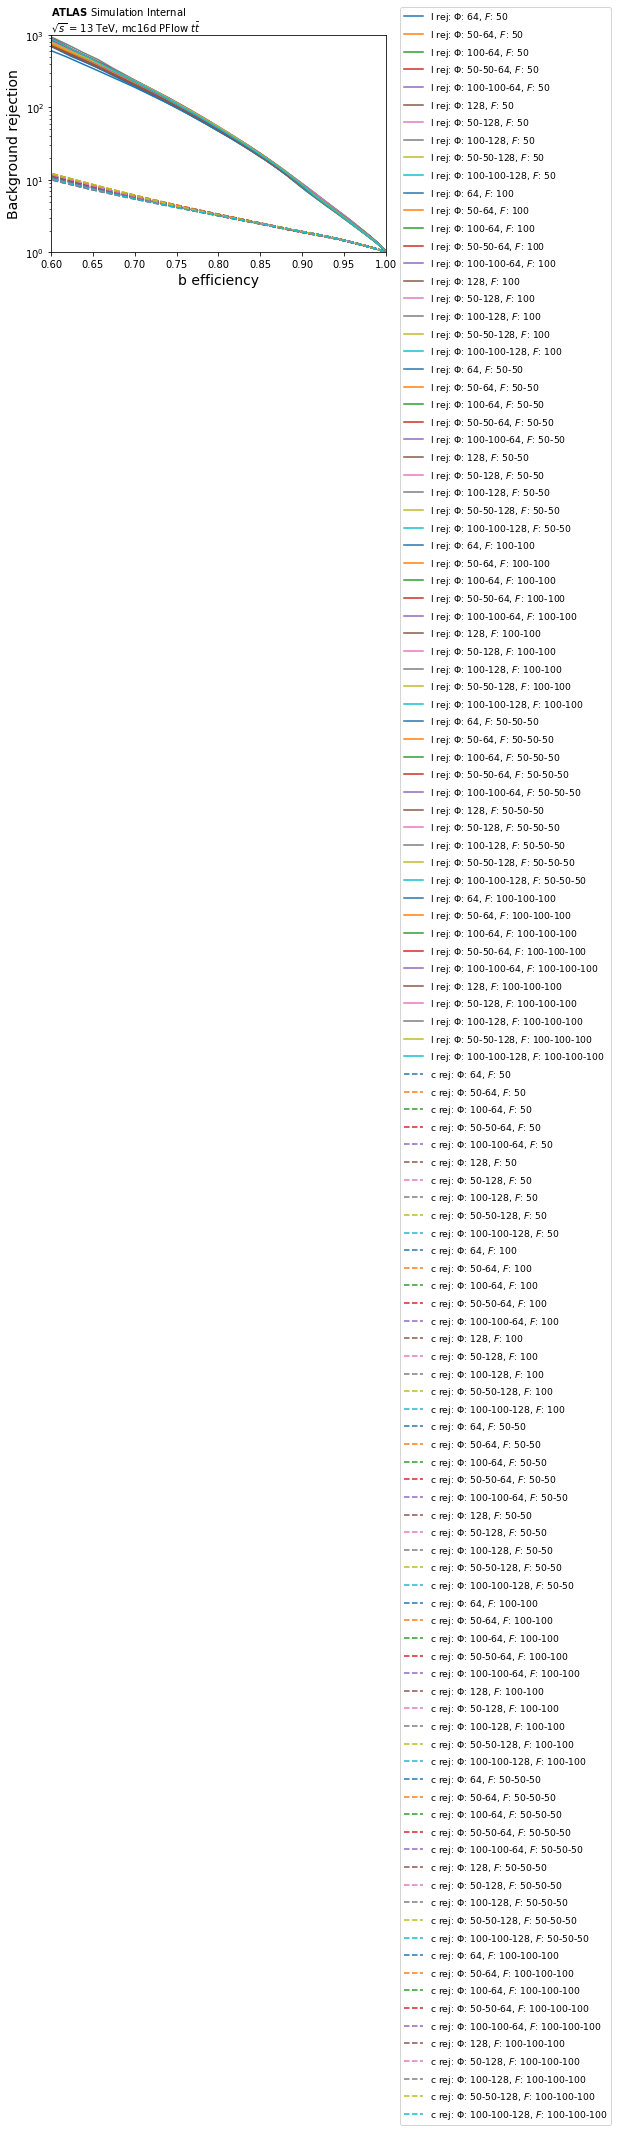

In [17]:
colors = ['C{}'.format(i % 10) for i,l in enumerate(labels)]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d " 
text+= jetCollection 
text+=r" $t\bar{t}$"

btagROC(beffs, leffs, ceffs, labels, colors=colors, 
        legFontSize=9.25, bbox_to_anchor=(1.03,1.15),text=text,
        figDir=figDir,subDir=subDir+'/deep-sets',tag='showAll')

This plot is saying when you fix the # of layers, it doesn't look like the performance is impacted that much by the size of these layers.

Just naively by looking at this plot, it looks like the story might be different in terms of the l and c rejection, like pink is the worst in terms of l-rej, but best in terms of c-rej?

**Lesson:** Ok, so we just showed that for the different models, there is a vast difference in the performance we can get, but the next question is: where does this performance *plateau*?

**Next plan:** I think I should start trying to plot the way this rejection varies as a function of the trainable parameters for $\Phi$ and $F$.

I want the *color* on this plot to correspond to the rejection value!

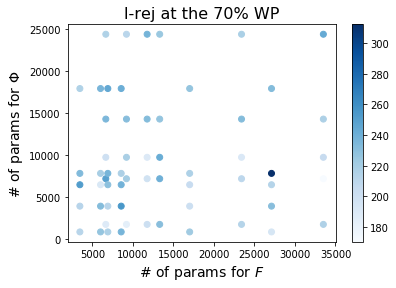

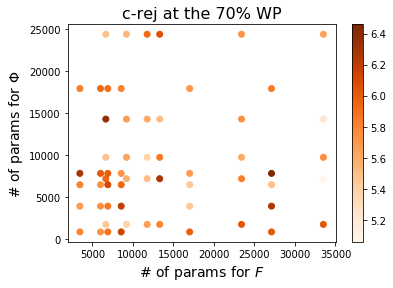

In [18]:
for rej, cmap, flav in zip([lrej_70,crej_70],['Blues','Oranges'],['l','c']):

    plt.figure()
    plt.scatter(nFs, nPhis, c=rej, cmap=cmap)
    plt.colorbar()
    plt.xlabel('# of params for $F$',fontsize=14)
    plt.ylabel('# of params for $\Phi$',fontsize=14)
    plt.title(flav+'-rej at the 70% WP',fontsize=16)
    
    plt.savefig(figDir+subDir+'/deep-sets/{}-rej_vs_pararms.pdf'.format(flav),bbox_inches='tight')
    plt.show()

**Question:** Which model is the best? (In terms of light rejection.)

In [8]:
iloc = max((r,i) for i,r in enumerate(lrej_70) )[1]

In [9]:
print('{}, l-rej = {:.0f}, c-rej = {:.1f}'.format(labels[iloc],lrej_70[iloc],crej_70[iloc]))

$\Phi$: 100-64, $F$: 100-100-100, l-rej = 312, c-rej = 6.5


Ok, so this is one of the models with the *most* complexity for the jet, but you don't need to encode as much complexity for the track classifier.



It might also be super cool to include one of my RNNs... maybe with like a star?

Oh, actually, I can't include the RNN explicitly because I don't have this break down in terms of the $\Phi$ and $F$, but if I just calculate the # myself, I could go ahead and just include it with an arrow on the graphic in my slide show presentation.

Ok, I think the result of this study is namely that more complex is better, except that it *might* be useful to use dropout in the latent dimension... but this shouldn't be too hard to train some other models to do this tomorrow!

*Maybe I should also try a more complex model?*

**Other stuff to try**
- Overfitting by plotting $\Delta$acc and $\Delta L$
- The weights distributions

**First let's look at how these metrics perform when you *fix* the jet part of the network, and vary the track part.**

In [86]:
dense_layers = 3
dense_size = 100
dense_sizes = [dense_size] * dense_layers

metrics = {
    'loss': [],
    'val_loss': [],
    'acc': [],
    'val_acc': []
}

phiParams, phiLabels = [], []

for latent_dim in [64,128]:
    for ppm_layers in [0,1,2]:    
        for ppm_size in [50, 100]:

            ppm_sizes = [ppm_size] * ppm_layers + [latent_dim]

            m = myPFN(ppm_sizes,dense_sizes,latent_dropout=0,
                      timeSteps=nTrks,nFeatures=nFeatures,
                      modelDir=modelDir,dataTag=dataTagTrain,loadModel=True)
            print(m.modelName)

            '''
            Plan: Load in the training metrics, and look at the training and validation loss and accuracy 
            where the early stopping criterion was applied.
            '''
            g = h5py.File("{}/{}_history.hdf5".format(m.modelDir,m.modelName),"r")

            # Since the early stopping metric is you stop if the accuracy hasn't improved in 20
            # epochs, you need to use the metrics from 21 steps ago to retrieve the saved model
            patience = 21
            
            for key in metrics.keys():
            
                metrics[key].append(g[key][:][-patience])

            phiParams.append( getParams([nFeatures] + ppm_sizes) )
            phiLabels.append("-".join([str(n) for n in ppm_sizes]))
            
            if ppm_layers == 0:
                break
            

Initialize method from myModel()
Loading previously trained PFN
PFN_phi_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_50_50_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCT

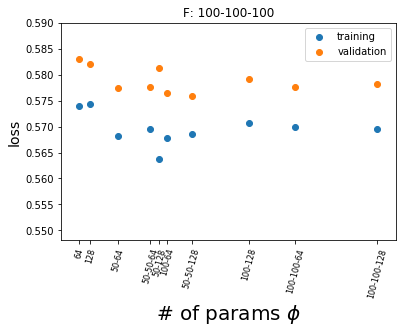

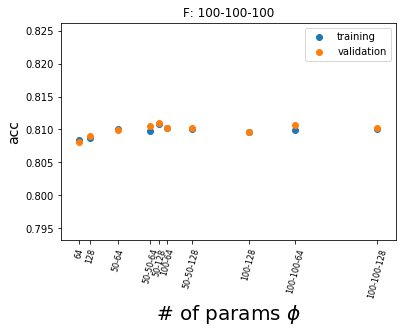

In [87]:
FTag = "-".join([str(n) for n in dense_sizes])

for m in ['loss','acc']:

    plt.figure()
    plt.scatter(phiParams,metrics[m],label='training')
    plt.scatter(phiParams,metrics['val_'+m],label='validation')
    
    plt.xticks(phiParams, phiLabels, fontsize=8, rotation=75)
    plt.xlabel('# of params $\phi$',fontsize=20)
    plt.ylabel(m,fontsize=14)
    plt.legend()
    plt.title('F: {}'.format(FTag))
    plt.savefig(figDir+subDir+'/deep-sets/{}-varyPhi.pdf'.format(m))

Ok, I think the conclusion is that since there's still a significant gap between all of the training and validation losses, I think I should try to look into some regularization tecniques to encourage the models to find some more optimal solutions.
- Regularizer for the weights
- Dropout

To look into the effectiveness of a weight regularizer, maybe it would be useful to c.f. some of the weights that are learned by a couple of the models? 

I plan to compare the following particle models with $F$: 100-100:100:
- $\Phi$: 64
- $\Phi$: 100-64
- $\Phi$: 100-100-64

In [81]:
dense_layers = 3
dense_size = 100
dense_sizes = [dense_size] * dense_layers

latent_dim = 64
ppm_size = 100

weights, wTags = [], []

for ppm_layers in [0,1,2]:    

    ppm_sizes = [ppm_size] * ppm_layers + [latent_dim]

    m = myPFN(ppm_sizes,dense_sizes,latent_dropout=0,
              timeSteps=nTrks,nFeatures=nFeatures,
              modelDir=modelDir,dataTag=dataTagTrain,loadModel=True)
    print(m.modelName)

    w = np.concatenate([wi.flatten() for wi in m.model.get_weights()]) 
    assert w.shape[0] == m.model.count_params()
    weights.append(w)
    wTags.append("$\Phi$: " + "-".join([str(n) for n in ppm_sizes]))


Initialize method from myModel()
Loading previously trained PFN
PFN_phi_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits
Initialize method from myModel()
Loading previously trained PFN
PFN_phi_100_100_64_F_100_100_100_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits


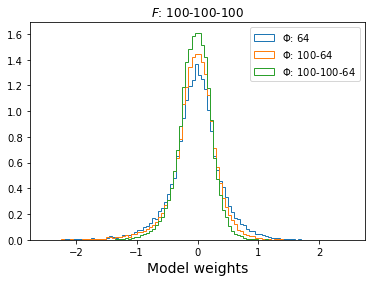

In [85]:
FTag = "-".join([str(n) for n in dense_sizes])

for w,l in zip(weights,wTags):

    plt.hist(w, histtype='step', label=l, bins=100,range=(-2.5,2.5), density=True)
    
plt.xlabel('Model weights',fontsize=14)
plt.legend()
plt.title('$F$: {}'.format(FTag))
plt.savefig(figDir+subDir+'/deep-sets/sampleWeights.pdf')
plt.show()

Interesting, as you increase the model complexity, the weights are slightly smaller.

But since these weights seem to be Gaussian distributed around 0 with a reasonable magnitude, I don't expect adding in a weight regularizer will help my problem.

It looks like many of these models are overfitting quite a bit, so I think I'll gain a lot by incorporating dropout in these models!

1. Dependence on the # of trainable parameters
2. Dependence on the size of the latent dimension
3. Impact of dropout

A great way to condense the performance metrics of these models would be to look at the rej at the 77% WP, and on the x-axis you could plot the # of trainable parameters!

Ok, so this might be a little bit time consuming, but perhaps I should *load* all of these metrics into the model?

(Another idea would be to *scriptify* this step so these metrics are easier to evaluate?)

Maybe I could start off by just loading in the models here, but save .h5 files with the efficiency curves?